# Import appropriate modules

In [89]:
import numpy as np
from numpy.linalg import eigh
np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3e}".format(x)})

import diatom.hamiltonian as hamiltonian
import diatom.calculate as calculate
from diatom.constants import Rb87Cs133

import scipy.constants

import matplotlib.pyplot as plt
import matplotlib.colors

import mpl_interactions.ipyplot as iplt
from mpl_interactions.controller import Controls

from functools import partial

#plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200
plt.rc('text.latex', preamble=r'\usepackage[T1]{fontenc}\usepackage{cmbright}')

%matplotlib widget
%config InlineBackend.figure_format = 'retina'

# Define 'global' Constants

In [2]:
H_BAR = scipy.constants.hbar

I1 = Rb87Cs133["I1"]
I2 = Rb87Cs133["I2"]
D_0 = Rb87Cs133["d0"]
N_MAX=1

I = 0 #W/m^2
E = 0 #V/m

GAUSS = 1e4 # T
B_MIN = 0.01 / GAUSS # T
B_MAX = 400 / GAUSS # T
B_STEPS = 400

B, B_STEP_SIZE = np.linspace(B_MIN, B_MAX, B_STEPS, retstep=True) #T

def btoi(b):
    return (b-B_MIN)/B_STEP_SIZE

def itob(i):
    return B_STEP_SIZE*i+B_MIN

# Build and Diagonalise Hamiltonian for many B

In [3]:
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(N_MAX, Rb87Cs133, zeeman=True, Edc=True, ac=True)

H = H0[..., None]+\
    Hz[..., None]*B+\
    Hdc[..., None]*E+\
    Hac[..., None]*I
H = H.transpose(2,0,1)

ENERGIES, STATES = eigh(H)

ENERGIES, STATES, LABELS = calculate.sort_by_state(ENERGIES, STATES, N_MAX, Rb87Cs133)

# Helper Functions

In [4]:
def label_to_state_no(N,MF,k):
    for i, label in enumerate(LABELS):
        if label[0] == N and label[1] == MF and label[2] == k:
            return i

def state_no_to_uncoupled_label(state_no):
    i=0
    I1d = int(I1*2)
    I2d = int(I2*2)
    for n in range(0, N_MAX + 1):
        for mn in range(n,-(n+1),-1):
            for mi1 in range(I1d,-I1d-1,-2):
                for mi2 in range(I2d,-I2d-1,-2):
                    if i == state_no:
                        return (n,mn,mi1/2,mi2/2)
                    i+=1

# General Constants

In [5]:
INITIAL_STATE_LABEL = (0,5,0)
INITIAL_STATE_POSITION = label_to_state_no(*INITIAL_STATE_LABEL)

# Ordered by energy low->high at 181.5G 
ACCESSIBLE_STATE_LABELS = [(1, 5, 0), (1, 4, 0), (1, 4, 1), (1, 6, 0), (1, 5, 1), (1, 4, 2), (1, 5, 2), (1, 4, 3), (1, 4, 4), (1, 4, 5)]
ACCESSIBLE_STATE_POSITIONS = [label_to_state_no(N,MF,k) for N,MF,k in ACCESSIBLE_STATE_LABELS]

CONSIDERED_STATE_LABELS = [INITIAL_STATE_LABEL] + ACCESSIBLE_STATE_LABELS
CONSIDERED_STATE_POSITIONS = [INITIAL_STATE_POSITION] + ACCESSIBLE_STATE_POSITIONS

STATE_CMAP = plt.cm.gist_rainbow(np.linspace(0,1,len(CONSIDERED_STATE_POSITIONS)))

# Plot energies over B for N=1 and N=2, highlighting available transitions from spin stretched group state

In [77]:
# Plot Transition Dipole Moments
dipole_op_pos = calculate.dipole(N_MAX,I1,I2,1,1)
tdm_matrices_pos = (STATES[:, :, CONSIDERED_STATE_POSITIONS].conj().transpose(0, 2, 1) @ (dipole_op_pos @ STATES[:, :, CONSIDERED_STATE_POSITIONS])).real

dipole_op_zero = calculate.dipole(N_MAX,I1,I2,1,0)
tdm_matrices_zero = (STATES[:, :, CONSIDERED_STATE_POSITIONS].conj().transpose(0, 2, 1) @ (dipole_op_zero @ STATES[:, :, CONSIDERED_STATE_POSITIONS])).real

dipole_op_neg = calculate.dipole(N_MAX,I1,I2,1,-1)
tdm_matrices_neg = (STATES[:, :, CONSIDERED_STATE_POSITIONS].conj().transpose(0, 2, 1) @ (dipole_op_neg @ STATES[:, :, CONSIDERED_STATE_POSITIONS])).real

/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


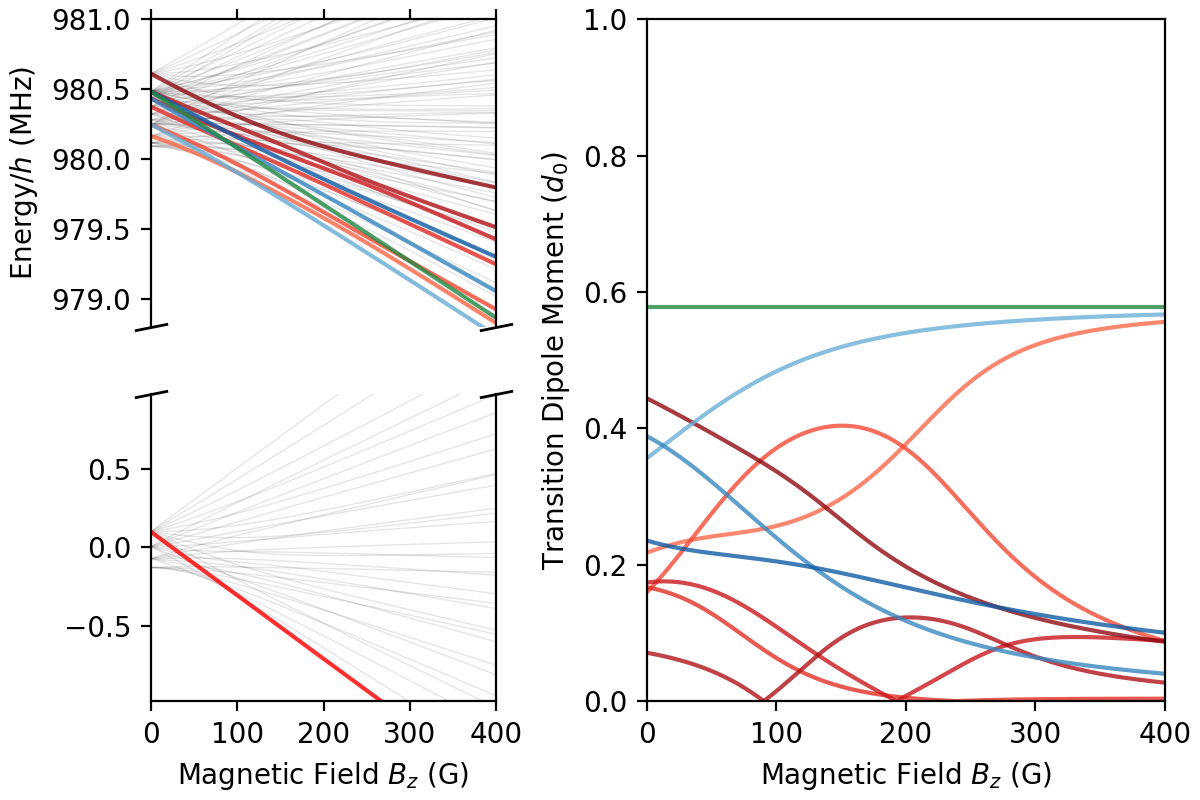

In [88]:
gs_kw = dict(width_ratios=[1, 1.5], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic([['upper left' ,'right'],
                               ['lower left' ,'right']],
                              gridspec_kw=gs_kw, figsize=(6, 4), layout="constrained",sharex=True
                              )
ax_up = axd["upper left"]
ax_down = axd["lower left"]
ax_dipoles = axd["right"]

ax_up.plot(B * GAUSS, ENERGIES * 1e-6 / scipy.constants.h, color='k', linewidth=0.5, alpha=0.1)
ax_down.plot(B * GAUSS, ENERGIES * 1e-6 / scipy.constants.h, color='k', linewidth=0.5, alpha=0.1)

a=0.8
lwid=1.5
ax_down.plot(B*GAUSS, ENERGIES[:,label_to_state_no(0,5,0)]*1e-6/scipy.constants.h, color='r', linewidth=lwid, alpha=a)

from matplotlib.pyplot import cm
cmap = cm.get_cmap('Reds')
for k in range(6):
    si = label_to_state_no(1,4,k)
    ci = CONSIDERED_STATE_POSITIONS.index(si)
    col = cmap(k/12+0.5)
    ax_up.plot(B*GAUSS, ENERGIES[:,si]*1e-6/scipy.constants.h, color=col, linewidth=lwid, alpha=a)
    ax_dipoles.plot(B * GAUSS, np.abs(tdm_matrices_pos[:, INITIAL_STATE_POSITION, ci]),color=col, linewidth=lwid, alpha=a)

cmap = cm.get_cmap('Blues')
for k in range(3):
    si = label_to_state_no(1,5,k)
    ci = CONSIDERED_STATE_POSITIONS.index(si)
    col = cmap(k/6+0.5)
    ax_up.plot(B*GAUSS, ENERGIES[:,si]*1e-6/scipy.constants.h, color=col, linewidth=lwid, alpha=a)
    ax_dipoles.plot(B * GAUSS, np.abs(tdm_matrices_zero[:, INITIAL_STATE_POSITION, ci]),color=col, linewidth=lwid, alpha=a)
    
cmap = cm.get_cmap('Greens')
for k in range(1):
    si = label_to_state_no(1,6,k)
    ci = CONSIDERED_STATE_POSITIONS.index(si)
    col = cmap(0.75)
    ax_up.plot(B*GAUSS, ENERGIES[:,si]*1e-6/scipy.constants.h, color=col, linewidth=lwid, alpha=a)
    ax_dipoles.plot(B * GAUSS, np.abs(tdm_matrices_neg[:, INITIAL_STATE_POSITION, ci]),color=col, linewidth=lwid, alpha=a)


# Plot Transition Dipole Moments
polarisation=1
dipole_op = calculate.dipole(N_MAX,I1,I2,1,polarisation)
tdm_matrices = (STATES[:, :, CONSIDERED_STATE_POSITIONS].conj().transpose(0, 2, 1) @ (dipole_op @ STATES[:, :, CONSIDERED_STATE_POSITIONS])).real

ax_dipoles.set_xlabel("Magnetic Field $B_z$ (G)")
ax_dipoles.set_ylabel(r"Transition Dipole Moment $(d_0)$")
ax_dipoles.set_xlim(0, B_MAX*GAUSS)
ax_dipoles.set_ylim(0, 1)
        
ax_up.set_xlim(0, B_MAX*GAUSS)
ax_up.set_ylim(978.8, 981.0)
ax_down.set_ylim(-0.98, 0.98)
ax_up.set_ylabel("Energy/$h$ (MHz)")
ax_down.set_xlabel("Magnetic Field $B_z$ (G)")

# Split axes formatting
ax_up.spines.bottom.set_visible(False)
ax_down.spines.top.set_visible(False)
ax_up.xaxis.tick_top()
ax_up.tick_params(labeltop=False)
ax_down.xaxis.tick_bottom()
d = .2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax_up.plot([0, 1], [0, 0], transform=ax_up.transAxes, **kwargs)
ax_down.plot([0, 1], [1, 1], transform=ax_down.transAxes, **kwargs)

fig.savefig('../images/zeeman-energies-tdm.pdf')

# State mixing composition over B

Text(0.5, 1.0, '$|N=1,M_F=4\\rangle_3$ composition')

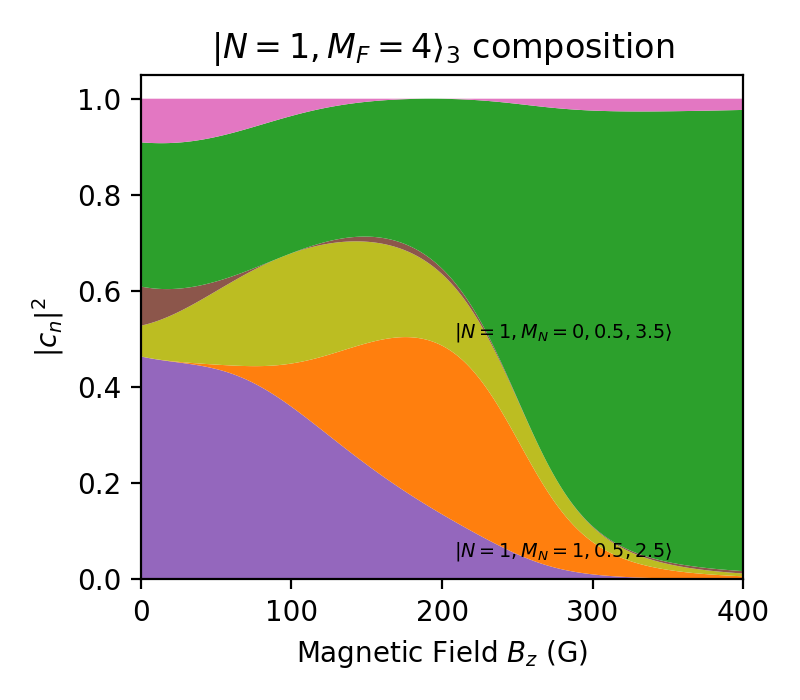

In [7]:
state_label_to_plot = (1, 4, 3)
state_num_to_plot = label_to_state_no(*state_label_to_plot)

fig, ax = plt.subplots()

ax.stackplot(B * 1e4, np.abs(STATES[:, :, state_num_to_plot].T) ** 2)

cumulative=0
for component_state_index, component_state_coef in enumerate(STATES[int(B_STEPS * 0.7), :, state_num_to_plot]):
    if np.abs(component_state_coef) > 0.25:
        component_state_label = state_no_to_uncoupled_label(component_state_index)
        component_state_label_string = r'$|N={},M_N={},{},{}\rangle$'.format(*component_state_label)
        component_state_fraction = np.abs(component_state_coef)**2
        ax.text(B[int(B_STEPS*0.7)]*1e4, cumulative+component_state_fraction/2, component_state_label_string,
                va='center', ha='center', fontsize='x-small')
        cumulative += component_state_fraction

ax.set_ylabel(r"$|c_n|^2$")
ax.set_xlabel(r"Magnetic Field $B_z$ (G)")
ax.set_ylim(0, 1.05)
ax.set_xlim(0, B_MAX*GAUSS)
ax.set_title(r"$|N={},M_F={}\rangle_{}$ composition".format(*state_label_to_plot))

#fig.show()

# A4 all states mixing plots

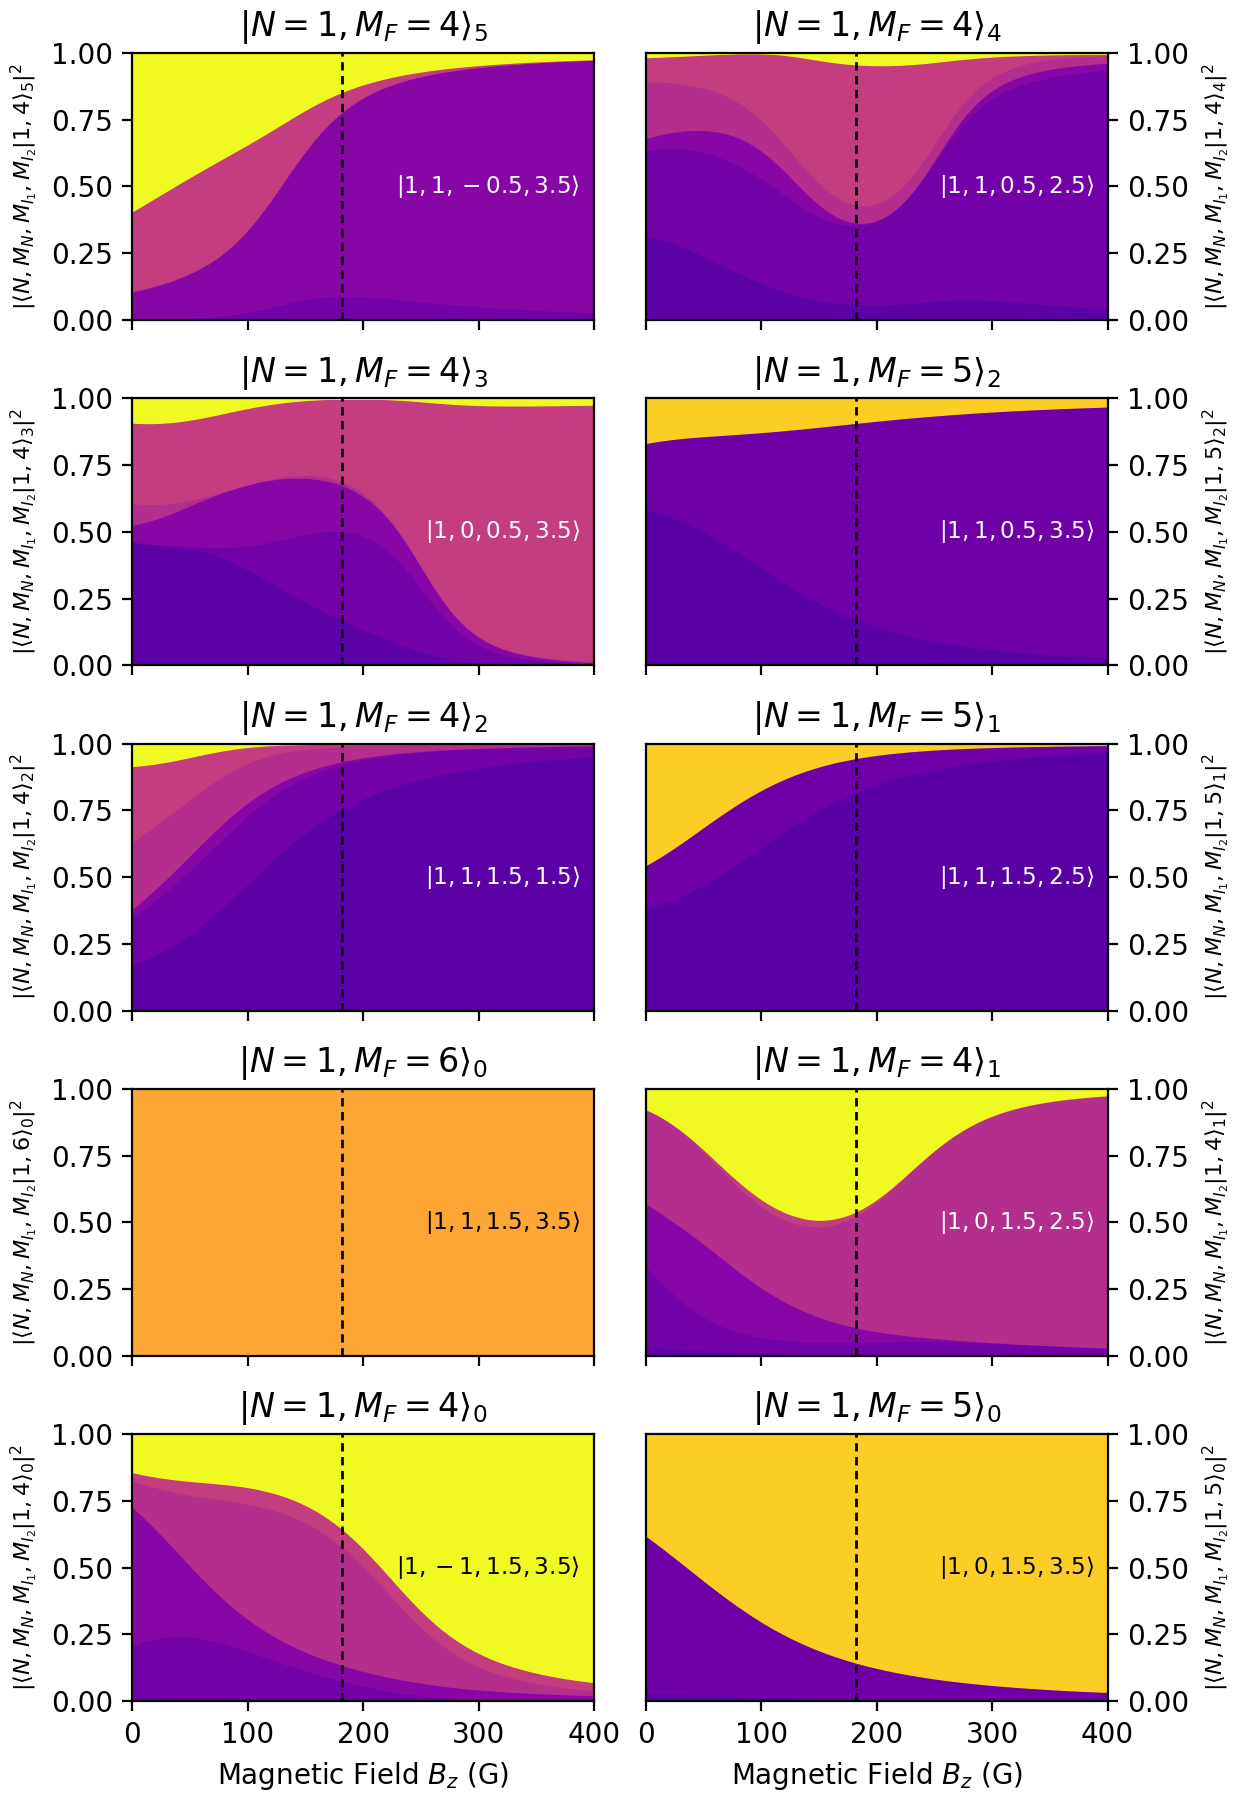

In [48]:
# Set DPI to 600 for print quality
fig, axs = plt.subplots(5,2, figsize=(6.2,9), sharex=True, layout="constrained")

state_labels_to_plot = np.flip(np.array(ACCESSIBLE_STATE_LABELS, dtype="i,i,i")).reshape(5,2)

for v, axrow in enumerate(axs):
    for h, ax in enumerate(axrow):
        state_label_to_plot = state_labels_to_plot[v][h]
        state_num_to_plot = label_to_state_no(*state_label_to_plot)

        state_coeffs_to_plot = np.abs(STATES[:, 32:128, state_num_to_plot].T) ** 2
        existence = np.sum(state_coeffs_to_plot,1)>0.1
        
        color_map = plt.cm.plasma
        colors = color_map(np.linspace(0.15, 0.9, len(state_coeffs_to_plot)))
        colors_special = color_map(np.linspace(0.8, 1, 3))
        colors[[0,32,64]] = colors_special
        
        reduced_state_coeffs_to_plot = state_coeffs_to_plot[existence]
        reduced_colours = colors[existence]

        ax.stackplot(B*1e4, reduced_state_coeffs_to_plot, colors=reduced_colours,lw=0.5,ec='face',aa=True)
        
        max_comp_state_index = state_coeffs_to_plot[:,-1].argmax()+32
        max_comp_state_label = state_no_to_uncoupled_label(max_comp_state_index)
        max_comp_state_label_string = r'$|{},{},{},{}\rangle$'.format(*max_comp_state_label)
        bg_col = matplotlib.colors.to_rgb(colors[max_comp_state_index-32])
        text_col = 'black' if (bg_col[0]*0.299 + bg_col[1]*0.587 + bg_col[2]*0.114) > 0.7 else 'white'
        ax.text(B_MAX*0.97*GAUSS, 0.5, max_comp_state_label_string,
                va='center', ha='right', fontsize='small',color=text_col)
        
        if h==1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")

        ax.set_ylim(0, 1)
        ax.set_xlim(0, B_MAX*GAUSS)
        ax.set_title(r'$|N={},M_F={}\rangle_{}$'.format(*state_label_to_plot))
        ax.axvline(x=181.5,dashes=(3, 2),color='k',linewidth=1)
        
        ax.set_ylabel(r"$|\langle N,M_N,M_{{I_1}},M_{{I_2}}|{},{}\rangle_{} |^2$".format(*state_label_to_plot),fontsize=8)

[ax.set_xlabel("Magnetic Field $B_z$ (G)") for ax in axs[4,:]]

fig.savefig('../images/10-state-zeeman.pdf')

# Transition Dipole Moments

(0.0, 1.0)

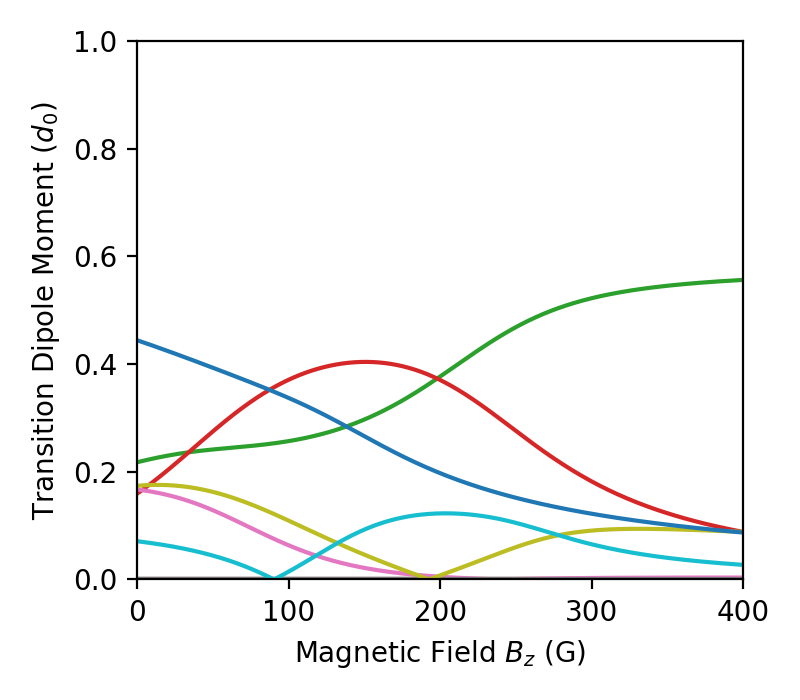

In [51]:
polarisation=1
dipole_op = calculate.dipole(N_MAX,I1,I2,1,polarisation)
tdm_matrices = (STATES[:, :, CONSIDERED_STATE_POSITIONS].conj().transpose(0, 2, 1) @ (dipole_op @ STATES[:, :, CONSIDERED_STATE_POSITIONS])).real

fig, ax = plt.subplots()
ax.plot(B * 1e4, np.abs(tdm_matrices[:, INITIAL_STATE_POSITION, :]))
ax.set_xlabel("Magnetic Field $B_z$ (G)")
ax.set_ylabel(r"Transition Dipole Moment $(d_0)$")
ax.set_xlim(0, B_MAX*GAUSS)
ax.set_ylim(0, 1)
#fig.show()

# Rabi oscillations
## Unitary `expm` method
$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}
$$
$$
\Omega_{ij} = \frac{E_0}{\hbar} \bra{i} \mathbf{\hat{d}} \cdot \mathbf{\hat{\epsilon}} \ket{j}
$$
$$
T_{ij} = e^{i(w_{ij}-w)t} + e^{i(w_{ij}+w)t}
$$
Forming an overall Hamiltonian, where $\odot$ represents element wise multiplication
$$
H_{ij} = \frac{\hbar}{2} \Omega_{ij} \odot T_{ij}
$$

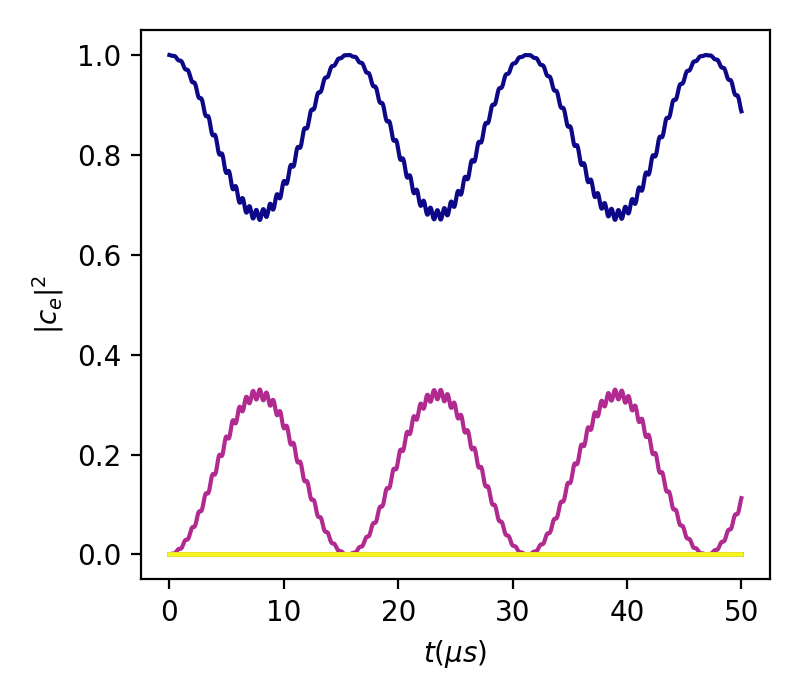

In [10]:
# Experimental Setup
POLARISATION = -1  # -1,0,1
DETUNING = 0 # rad/s
E_0 = 10  # V/m
AT_B_NUM = int(B_STEPS/2)
T_STEPS = 2000
initial_state_considered_index = 0
intended_state_considered_index = 3

N_STATES = len(CONSIDERED_STATE_POSITIONS)

# Relevent energies as frequencies
angular = ENERGIES[AT_B_NUM, CONSIDERED_STATE_POSITIONS].real / H_BAR
driving = angular[intended_state_considered_index] - angular[initial_state_considered_index] + DETUNING

# Construct Rabi coupling matrix
dipole_op = calculate.dipole(N_MAX,I1,I2,D_0,POLARISATION)
coupling = STATES[AT_B_NUM, :, CONSIDERED_STATE_POSITIONS].conj() @ dipole_op @ STATES[AT_B_NUM, :, CONSIDERED_STATE_POSITIONS].T
rabi = (E_0/H_BAR) * coupling

# Construct Time-dependent part
transition_rabi = np.abs(rabi[initial_state_considered_index, intended_state_considered_index])
PULSE_TIME = 2*np.pi/transition_rabi if transition_rabi != 0 else 50e-6
times, DT = np.linspace(0, PULSE_TIME, num=T_STEPS, retstep=True)

wij = angular[:,np.newaxis]-angular[np.newaxis,:]
neg_frequency_part = wij-driving
pos_frequency_part = wij+driving

Ts = np.exp((1j)*neg_frequency_part[np.newaxis,:,:]*times[:,np.newaxis,np.newaxis]) + \
     np.exp((1j)*pos_frequency_part[np.newaxis,:,:]*times[:,np.newaxis,np.newaxis]) #[ti,i,j]

# Construct overall Hamiltonians
Hs = H_BAR/2 * rabi[np.newaxis,:,:] * Ts[:,:,:]  #[ti,i,j]

# Initialise states for each B
state_vector = np.zeros((N_STATES)) # initial state
state_vector[initial_state_considered_index] = 1

# Churn Differential equation
DUs = scipy.linalg.expm(-(1j/H_BAR) * Hs * DT) # Infitesimal unitary transformations

finals = []

for t_num in range(T_STEPS):
    state_vector = DUs[t_num,:,:] @ state_vector
    finals.append(np.abs(state_vector)**2)

fig, ax = plt.subplots()
#ax.set_xlim(0,T_MAX)
#ax.set_ylim(0,1)
ax.set_xlabel("$t (\mu s)$")
ax.set_ylabel("$|c_e|^2$")

colors = plt.cm.plasma(np.linspace(0,1,N_STATES))
for i,final in enumerate(np.array(finals).T):
    ax.plot(times*1e6, final, c=colors[i])
#fig.show()

# Transfer efficiency
## Split Operator Method
Using a split operator method based on the The Lie product formula and it's Suzuki–Trotter expansion
$$\hat{H} = T + V = \hat{H}_0 + d \cdot E(t)$$
as a matrix
$$TODO$$
Then
$$\psi(t+\Delta t) = e^{-\frac{i}{\hbar} (T+V)\Delta T} \psi(t) = e^{-\frac{i}{\hbar}T\Delta t/2}e^{-\frac{i}{\hbar}V\Delta t}e^{-\frac{i}{\hbar}T\Delta t/2}\psi(t) + O((\Delta t)^3)$$

Memory Usage:

$$ sizeof(CDOUBLE) * T * B * S^2$$

E.g. for 5000 T Steps, 300 B steps, and 11 States:
$$(8*2)*5000*300*11^2 = 2,904,000,000 B = 2.9 GB$$

In [11]:
%%time
#for intended_state_label in ACCESSIBLE_STATE_LABELS:
# Experimental Setup
POLARISATION = 0 # -1,0,1
DETUNING = 0
PULSE_TIME = 100e-6 # s
T_STEPS = 10000
initial_state_label = (0,5,0)
intended_state_label = (1,4,5)
POLARISATION=initial_state_label[1]-intended_state_label[1]

initial_state_considered_index = CONSIDERED_STATE_LABELS.index(initial_state_label)
intended_state_considered_index = CONSIDERED_STATE_LABELS.index(intended_state_label)
initial_state_real_index = CONSIDERED_STATE_POSITIONS[initial_state_considered_index]
intended_state_real_index = CONSIDERED_STATE_POSITIONS[intended_state_considered_index]

N_STATES = len(CONSIDERED_STATE_POSITIONS)

# Get Angular Frequency Matrix Diagonal for each B
angular = ENERGIES[:, CONSIDERED_STATE_POSITIONS].real / H_BAR # [B_Number, state]

# Get Driving Frequency for each B
driving = angular[:, intended_state_considered_index].T - angular[:, initial_state_considered_index] + DETUNING # [B_Number]

# Get Rabi coupling matrix for each B
dipole_op = calculate.dipole(N_MAX,I1,I2,1,POLARISATION)
couplings = STATES[:, :, CONSIDERED_STATE_POSITIONS].conj().transpose(0, 2, 1) @ (dipole_op @ STATES[:, :, CONSIDERED_STATE_POSITIONS])
E_0 = np.abs((2*np.pi*H_BAR) / (D_0 * couplings[:, initial_state_considered_index, intended_state_considered_index] * PULSE_TIME))

# Construct Times
times, DT = np.linspace(0, PULSE_TIME, num=T_STEPS, retstep=True)# [ti], []

# Construct 'kinetic' time step operator (Matrix Diagonal)
T_OP_DIAG = np.exp(-(1j) * angular * DT/2 )
T_OP = np.array([np.diag(v) for v in T_OP_DIAG])

# Construct potential fixed part time step operator 
ORDER = 6

V_TI_M = (-(1j)*D_0*DT/H_BAR)*E_0[:,None,None]*couplings #[Bi,i,j]
V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)]) #[c,Bi,i,j]

#Initialise states for each B
state_vectors = np.zeros((T_STEPS,B_STEPS,N_STATES), dtype=np.cdouble) # initial state
state_vectors[0,:, initial_state_considered_index] = 1

for t_num in range(T_STEPS-1):
    
    V_TD = np.cos(driving*times[t_num]) # bi
    V_TD_POWS = np.array([V_TD**i for i in range(ORDER)])
    
    V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[...,None,None],axis=0) # [Bi,i,j]

    DU = T_OP @ V_OP @ T_OP
    state_vectors[t_num+1] =  np.einsum('bij,bi->bj', DU, state_vectors[t_num])

max_vector = (np.abs(state_vectors)**2).max(axis=0) #[bi,i]

CPU times: user 16.5 s, sys: 3.87 s, total: 20.4 s
Wall time: 18.3 s


/Users/tom/Code/project/diatom-notebooks/venv/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, 'Detuning $(\\Omega)$')

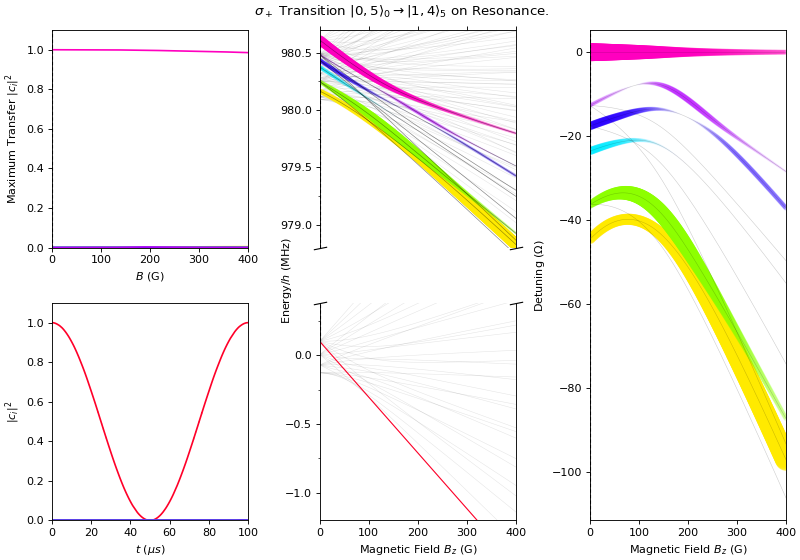

In [12]:
# Create axes
gs_kw = dict(width_ratios=[1, 1, 1], height_ratios=[1, 1])
fig, axd = plt.subplot_mosaic([['upper left','upper middle' ,'right'],
                               ['lower left','lower middle' ,'right']],
                              gridspec_kw=gs_kw, figsize=(10, 7), dpi=80, layout="constrained"
                              )
ax_max_trans = axd["upper left"]
ax_rabi_osc = axd["lower left"]
ax_up_zeeman = axd["upper middle"]
ax_down_zeeman = axd["lower middle"]
ax_detuning = axd["right"]

# Create controls
controls = Controls(bi=range(B_STEPS))
display(controls)

# Set figure title
p_string = [r"\pi",r"\sigma_+",r"\sigma_-"]
fig.suptitle(r" ${}$ Transition $|{},{}\rightangle_{} \rightarrow |{},{}\rightangle_{}$ on Resonance.".format(p_string[POLARISATION],*initial_state_label,*intended_state_label))

# Setup Max Transfer plot
for state_no in range(1,N_STATES):
    ax_max_trans.plot(B * GAUSS, max_vector[:, state_no], c=STATE_CMAP[state_no])

ax_max_trans.set_xlim(0, B_MAX * GAUSS)
ax_max_trans.set_ylim(0, 1.1)
ax_max_trans.set_xlabel("$B$ (G)")
ax_max_trans.set_ylabel("Maximum Transfer $|c_i|^2$")
iplt.axvline(x=lambda bi: B[bi]*GAUSS, ax=ax_max_trans, controls=controls, dashes=(3, 2), color='k', linewidth=1)

# Setup Rabi Oscillation plot
plt.sca(ax_rabi_osc) # set current matplotlib axes

def to_plot(t,bi,si):
    return np.abs(state_vectors[:,bi,si])**2

with controls["bi"]:
    for i in range(10):
        partial_f = partial(to_plot, si=i)
        iplt.plot(times * 1e6, partial_f,c=STATE_CMAP[i])

    #iplt.title(lambda bi: f"$E_0$={E_0[bi]:.2f} V/m")

ax_rabi_osc.set_xlim(0, PULSE_TIME * 1e6)
ax_rabi_osc.set_ylim(0, 1.1)
ax_rabi_osc.set_xlabel("$t$ $(\mu s)$")
ax_rabi_osc.set_ylabel("$|c_i|^2$")

# Setup Zeeman plots & Detuning
# Plot all energies lightly on zeeman
ax_up_zeeman.plot(B * GAUSS, ENERGIES * 1e-6 / scipy.constants.h, color='k', linewidth=0.5, alpha=0.1, zorder=1)
ax_down_zeeman.plot(B * GAUSS, ENERGIES * 1e-6 / scipy.constants.h, color='k', linewidth=0.5, alpha=0.1, zorder=1)

# Highlight specific lower state
ax_down_zeeman.plot(B * GAUSS, ENERGIES[:, initial_state_real_index] * 1e-6 / scipy.constants.h, color=STATE_CMAP[initial_state_considered_index], linewidth=1)
# Highlight specific upper states
for sub_index, real_index in enumerate(ACCESSIBLE_STATE_POSITIONS):
    sub_index += 1
    metric = np.abs(couplings[:, initial_state_considered_index, sub_index])
    this_colour = STATE_CMAP[sub_index]
    # Zeeman plot levels
    energy_mhz =  ENERGIES[:, real_index] * 1e-6 / scipy.constants.h
    ax_up_zeeman.plot(B * GAUSS, energy_mhz,
                      color='k', alpha=0.4, linewidth=0.6, zorder=3
                      )
    ax_up_zeeman.scatter(B * GAUSS, energy_mhz,
                         color=this_colour, edgecolors=None, alpha=metric, s=metric ** 2 * 300, zorder=2
                         )
    # Detuning plot levels
    detuning_rabi = ((ENERGIES[:, real_index] - ENERGIES[:, intended_state_real_index]) / scipy.constants.h) / (1/PULSE_TIME)
    ax_detuning.plot(B * GAUSS, detuning_rabi, color='k', alpha=0.2, linewidth=0.5, zorder=3)
    ax_detuning.scatter(B * GAUSS, detuning_rabi, color=this_colour, edgecolors=None, alpha=metric,
                        s=metric ** 1.8 * 1000, zorder=2)

LOWER_LIMS = (-1.2, 0.38)
UPPER_LIMS = (978.8, 980.7)
ax_up_zeeman.set_xlim(0, B_MAX * GAUSS)
ax_down_zeeman.set_xlim(0, B_MAX * GAUSS)
ax_up_zeeman.set_ylim(UPPER_LIMS)
ax_down_zeeman.set_ylim(LOWER_LIMS)
ax_up_zeeman.set_ylabel(" ")
fig.text(0.35, 0.5, 'Energy/$h$ (MHz)', ha='left',va='center', rotation='vertical')
ax_down_zeeman.set_xlabel("Magnetic Field $B_z$ (G)")
ax_up_zeeman.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax_up_zeeman.yaxis.set_minor_locator(plt.MultipleLocator(0.25))
ax_down_zeeman.yaxis.set_major_locator(plt.MultipleLocator(0.5))
ax_down_zeeman.yaxis.set_minor_locator(plt.MultipleLocator(0.25))

# Draw vlines
lower_in_all=CONSIDERED_STATE_POSITIONS[initial_state_considered_index]
upper_in_all=CONSIDERED_STATE_POSITIONS[intended_state_considered_index]
line_ratio = lambda bi, state, limits: (ENERGIES[bi,state].real*1e-6/scipy.constants.h-limits[0])/(limits[1]-limits[0])
iplt.axvline(x=lambda bi: B[bi]*GAUSS, ymax=lambda bi: line_ratio(bi,upper_in_all,UPPER_LIMS), controls=controls["bi"], ax=ax_up_zeeman, dashes=(3, 2), color='k', linewidth=1)
iplt.axvline(x=lambda bi: B[bi]*GAUSS, ymin=lambda bi: line_ratio(bi,lower_in_all,LOWER_LIMS), controls=controls["bi"], ax=ax_down_zeeman, dashes=(3, 2), color='k', linewidth=1)
iplt.axvline(x=lambda bi: B[bi]*GAUSS, controls=controls["bi"], ax=ax_detuning, dashes=(3, 2), color='k', linewidth=1)

# Split axes formatting on zeeman
ax_up_zeeman.spines.bottom.set_visible(False)
ax_down_zeeman.spines.top.set_visible(False)
ax_up_zeeman.xaxis.tick_top()
ax_up_zeeman.tick_params(labeltop=False)
ax_down_zeeman.xaxis.tick_bottom()
d = .2  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12, linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax_up_zeeman.plot([0, 1], [0, 0], transform=ax_up_zeeman.transAxes, **kwargs)
ax_down_zeeman.plot([0, 1], [1, 1], transform=ax_down_zeeman.transAxes, **kwargs)

# Setup detuning plot
ax_detuning.set_xlim(0, B_MAX * GAUSS)
ax_detuning.set_xlabel("Magnetic Field $B_z$ (G)")
ax_detuning.set_ylabel("Detuning $(\Omega)$")
#ax_detuning.yaxis.set_major_locator(plt.MultipleLocator(5))
#ax_detuning.yaxis.set_minor_locator(plt.MultipleLocator(2.5))

#anim = controls.save_animation("bsliding{}-{}-{}.mp4".format(*intended_state_label), fig, "bi", interval=100)

#fig.show()

# Equivelent single rabi

Text(0, 0.5, 'Detuning $(\\Omega)$')

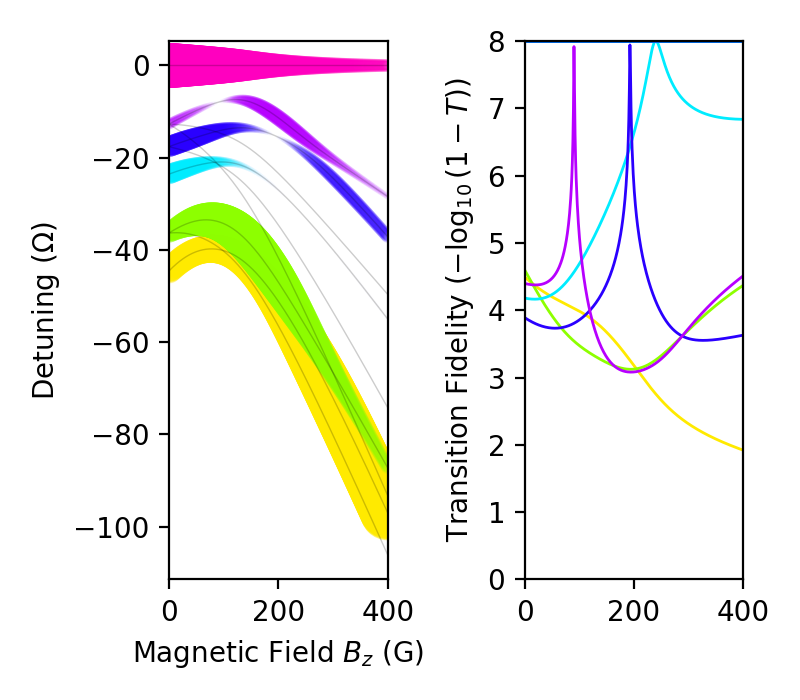

In [13]:
fig,(ax,axr) = plt.subplots(1,2)
i=0
for sub_index, real_index in enumerate(ACCESSIBLE_STATE_POSITIONS):
    sub_index += 1
    absg=np.abs(couplings[:, initial_state_considered_index, sub_index])
    g = np.abs(couplings[:, initial_state_considered_index, sub_index]/couplings[:, initial_state_considered_index, intended_state_considered_index])
    this_colour = STATE_CMAP[sub_index]
    # Detuning plot levels
    k = ((ENERGIES[:, real_index] - ENERGIES[:, intended_state_real_index]) / scipy.constants.h) / (1/PULSE_TIME)
    ax.plot(B * GAUSS, k, color='k', alpha=0.2, linewidth=0.5, zorder=3)
    ax.scatter(B * GAUSS, k, color=this_colour, edgecolors=None, alpha=absg, s=absg ** 1.8 * 1000, zorder=2)
    average = ((1 + g**2)**2 + 8*(-1 + 2*g**2)*k**2 + 16*k**4) / ((1 + g**2)**3 + (-8 + 20*g**2 + g**4)*k**2 + 16*k**4)
    if sub_index == intended_state_considered_index:
        continue
    axr.plot(B * GAUSS, -np.log10(1-average+1e-8), color=this_colour, alpha=1, linewidth=1)
    
#axr.set_ylim(0,1.1)
#ax2 = axr.twinx()
axr.set_ylim(0,8)
axr.set_ylabel("Transition Fidelity $(-\log_{10}(1-T))$")
#ax2.set_yticks(np.linspace(0,8,9),100*(1-np.logspace(0,-8,9)))

ax.set_xlim(0, B_MAX * GAUSS)
axr.set_xlim(0, B_MAX * GAUSS)
ax.set_xlabel("Magnetic Field $B_z$ (G)")
ax.set_ylabel("Detuning $(\Omega)$")

# 2-parameter plots

In [14]:
PULSE_MIN = 10e-6
PULSE_MAX = 1e-3
PULSE_NUM = 40
PULSE_TIMES = np.linspace(PULSE_MIN,PULSE_MAX,num=PULSE_NUM)

def phase_fidelity(intended_state_label,T_STEPS=10000):

    #T_STEPS = 20000
    initial_state_label = (0,5,0)
    #intended_state_label = (1,4,4)
    POLARISATION=initial_state_label[1]-intended_state_label[1]

    initial_state_considered_index = CONSIDERED_STATE_LABELS.index(initial_state_label)
    intended_state_considered_index = CONSIDERED_STATE_LABELS.index(intended_state_label)
    initial_state_real_index = CONSIDERED_STATE_POSITIONS[initial_state_considered_index]
    intended_state_real_index = CONSIDERED_STATE_POSITIONS[intended_state_considered_index]

    N_STATES = len(CONSIDERED_STATE_POSITIONS)

    # Get Angular Frequency Matrix Diagonal for each B
    angular = ENERGIES[:, CONSIDERED_STATE_POSITIONS].real / H_BAR # [bi, i]

    # Get Driving Frequency for each B
    driving = angular[:, intended_state_considered_index].T - angular[:, initial_state_considered_index] + DETUNING # [bi]

    # Get Rabi coupling matrix for each B
    dipole_op = calculate.dipole(N_MAX,I1,I2,1,POLARISATION)
    couplings = STATES[:, :, CONSIDERED_STATE_POSITIONS].conj().transpose(0, 2, 1) @ (dipole_op @ STATES[:, :, CONSIDERED_STATE_POSITIONS])

    # Get desired E field for each B and rabi frequency
    #[pi,bi]
    E_0 = np.abs((2*np.pi*H_BAR) / (D_0 * couplings[None, :, initial_state_considered_index, intended_state_considered_index] * PULSE_TIMES[:,None]))

    # Construct Times
    times, DT = np.linspace(0, PULSE_TIMES, num=T_STEPS, retstep=True)# [ti,pi], [pi]

    # # Construct 'kinetic' time step operator (Matrix Diagonal)
    T_OP_DIAG = np.exp(-(1j) * angular[None,:,:] * DT[:,None,None]/2 ) # [pi,bi,i]

    # Construct potential fixed part time step operator 
    ORDER = 6

    V_TI_M = (-(1j)*D_0*DT[:,None,None,None]/H_BAR)*E_0[:,:,None,None]*couplings #[pi,bi,i,j]
    V_TI_M_POWS = np.array([np.linalg.matrix_power(V_TI_M, i)/np.math.factorial(i) for i in range(ORDER)]) #[c,pi,bi,i,j]

    #Initialise states for each B
    state_vector = np.zeros((PULSE_NUM,B_STEPS,N_STATES), dtype=np.cdouble)
    state_vector[:,:, initial_state_considered_index] = 1
    max_amp_vector = np.zeros((PULSE_NUM,B_STEPS,N_STATES), dtype=np.double)
    max_amp_vector[:,:, initial_state_considered_index] = 1

    path = np.einsum_path('pbij,pbi->pbj',V_TI_M,state_vector, optimize='optimal')[0]
    for t_num in range(T_STEPS-1):

        V_TD = np.cos(driving[None,:]*times[t_num,:,None]) # [pi,bi]
        V_TD_POWS = V_TD[None,...]**(np.arange(ORDER)[:,None,None]) # [ci,pi,bi]
        V_OP = np.sum(V_TI_M_POWS*V_TD_POWS[...,None,None],axis=0) # [pi,bi,i,j]

        DU = T_OP_DIAG[:,:,:,None] * V_OP[:,:,:,:] * T_OP_DIAG[:,:,None,:]
        state_vector = np.einsum('pbij,pbi->pbj',DU,state_vector, optimize=path)
        max_amp_vector = np.maximum(max_amp_vector, np.abs(state_vector))

    return max_amp_vector**2

In [15]:
# Set to higher T_STEPS=25000 for example
max_prob_vectors = [phase_fidelity(intended, T_STEPS=10) for intended in ACCESSIBLE_STATE_LABELS]

/var/folders/lt/2lfqhmyn1n9bbwg1sqf3zzwc0000gn/T/ipykernel_11727/3334986974.py:63: RuntimeWarning: overflow encountered in square
  return max_amp_vector**2


[Text(0.5, 0, 'Magnetic Field $B_z$ (G)'),
 Text(0.5, 0, 'Magnetic Field $B_z$ (G)')]

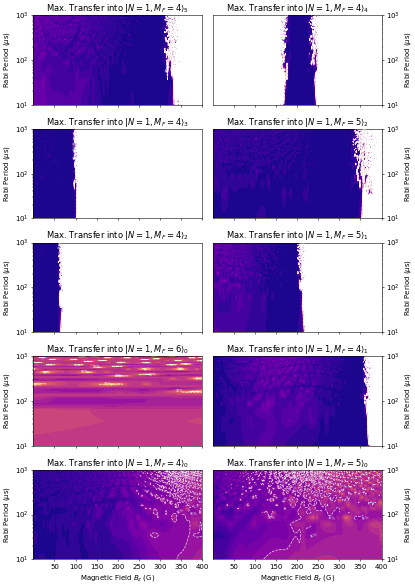

In [16]:
# Set DPI to 600 for print quality
fig, axs = plt.subplots(5,2, figsize=(8.3,11.7), dpi=50, sharex=True, layout="constrained")

state_labels_to_plot = np.flip(np.array(ACCESSIBLE_STATE_LABELS, dtype="i,i,i")).reshape(5,2)

for v, axrow in enumerate(axs):
    for h, ax in enumerate(axrow):
        initial_state_label = tuple(state_labels_to_plot[v][h])
        intended_state_considered_index=CONSIDERED_STATE_LABELS.index(initial_state_label)
        max_prob_vector = max_prob_vectors[intended_state_considered_index-1]

        b_grid, p_grid = np.meshgrid(B,PULSE_TIMES)

        CLIP=0.0005
        def _forward(x):
            return np.log(1-x+CLIP)/np.log(CLIP)
        def _inverse(x):
            return 1+CLIP-CLIP^x

        levels = 1-np.logspace(0,-7,50)
        levels=np.append(levels,1.0)
        norm = matplotlib.colors.FuncNorm((_forward, _inverse), vmin=0, vmax=1, clip=True)

        noted_levels=[0.9,0.99,0.999,0.9999]
        cf = ax.contourf(b_grid*GAUSS,p_grid*1e6,max_prob_vector[:,:,intended_state_considered_index], levels, cmap='plasma', norm=norm)
        CS1 = ax.contour(b_grid*GAUSS,p_grid*1e6,max_prob_vector[:,:,intended_state_considered_index],noted_levels,
                         colors='w',linestyles='dashed',linewidths=1,alpha=0.8)

        fmt = {}
        strs = ["90%","99%","99.9%","99.99%"]
        for l, s in zip(CS1.levels, strs):
            fmt[l] = s

        ax.clabel(CS1, CS1.levels, inline=True, fmt=fmt, fontsize=5)
        #fig.colorbar(cf, ax=ax)
        #ax.set_xlim(F_MIN,F_MAX)
        ax.set_yscale('log')
        #ax.set_xlabel("Rabi Frequency $\Omega$ (Hz)")
        #ax.set_xlabel("Magnetic Field $B_z$ (G)")
        ax.set_ylabel("Rabi Period ($\mu$s)")
        ax.set_title("Maximum Transfer $|c_i|^2$")
        title="phase{}-{}-{}.png".format(*intended_state_label)
        p_string = [r"\pi",r"\sigma_+",r"\sigma_-"]
        POLARISATION=initial_state_label[1]-intended_state_label[1]
        #fig.suptitle(r" ${}$ Transition $|{},{}\rightangle_{} \rightarrow |{},{}\rightangle_{}$ on Resonance.".format(p_string[POLARISATION],*initial_state_label,*intended_state_label))
        
        if h==1:
            ax.yaxis.tick_right()
            ax.yaxis.set_label_position("right")
        ax.set_title(r'Max. Transfer into $|N={},M_F={}\rangle_{}$'.format(*initial_state_label))
        

[ax.set_xlabel("Magnetic Field $B_z$ (G)") for ax in axs[4,:]]

# Find Magnetic Moments

In [17]:
magnetic_moments = calculate.magnetic_moment(STATES, N_MAX, Rb87Cs133)

Text(0.5, 0, 'Magnetic Field $B_z$ (G)')

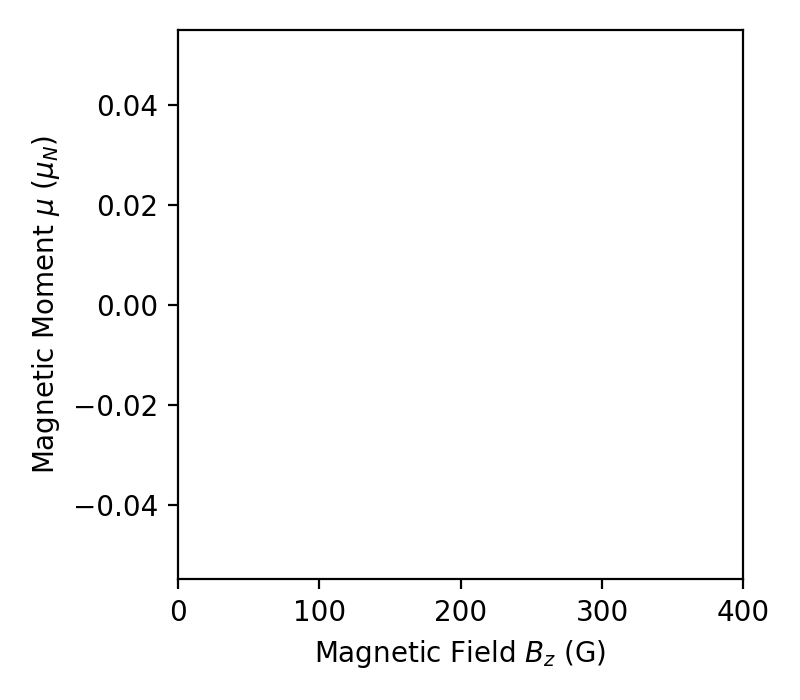

In [18]:
fig, ax = plt.subplots()
muN = scipy.constants.physical_constants['nuclear magneton'][0]
#import itertools

focus_moments = magnetic_moments[:,128:].T
#to_plot = [(0,5,0),(0,4,0),(0,3,0),(0,4,1),(0,3,1),(0,3,2)]
#to_plot_indices = np.array([label_to_state_no(N,MF,k) for N,MF,k in to_plot])

#c = plt.cm.gist_rainbow(np.linspace(0,1,96))
#for moment in focus_moments:
    #this_c = c[i]
ax.plot(B*GAUSS,focus_moments.T/muN, color = 'grey', alpha=0.3,linewidth=0.5,zorder=0);
    #ax.text(1.02*B_MAX*GAUSS, moment[-1]/muN, r'$|N={},M_F={}\rangle_{}$'.format(int(label[0]),int(label[1]),int(label[2])), va='center', ha='left', fontsize=2, color = this_c)
    
    #Find coincidences

# for moment_a,moment_b in itertools.combinations(focus_moments,2):
#     diff = moment_a-moment_b
#     sign_flip_low_indices = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0]
#     xs = (B[sign_flip_low_indices] + B[sign_flip_low_indices+1])*GAUSS/2
#     ys = (moment_a[sign_flip_low_indices]+moment_a[sign_flip_low_indices+1])/(2*muN)
#     ax.scatter(xs, ys,color='k',s=0.4,zorder=1)
    
#ax.set_ylim(5.5,1.5)
ax.set_xlim(0,B_MAX*GAUSS)
ax.set_ylabel("Magnetic Moment $\mu$ $(\mu_N)$")
ax.set_xlabel("Magnetic Field $B_z$ (G)")